In [1]:
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ntm import NTM
from recurrent_controller import RecurrentController

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 15)

In [2]:
def generate_data(batch_size, length, size):
    input_data = np.zeros((batch_size, 2 * length + 2, size), dtype=np.float32)
    target_output = np.zeros((batch_size, 2 * length + 2, size), dtype=np.float32)

    sequence = np.random.binomial(1, 0.5, (batch_size, length, size - 2))
    input_data[:, 0, 0] = 1
    input_data[:, 1:length+1, 1:size-1] = sequence
    input_data[:, length+1, -1] = 1  # the end symbol
    target_output[:, length + 2:, 1:size-1] = sequence

    return input_data, target_output

def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

In [3]:
def binary_cross_entropy(predictions, targets):
    return tf.reduce_mean(-1 * targets * tf.log(predictions) - (1 - targets) * tf.log(1 - predictions))

In [4]:
def visualize_op(input_series, ntm_output, memory_view):
    gs = gridspec.GridSpec(25, 1, hspace=0)

    ww_strip = np.squeeze(memory_view['write_weightings'])
    rw_strip = np.squeeze(memory_view['read_weightings'])
    colored_write = np.zeros((ww_strip.shape[0], ww_strip.shape[1], 3))
    colored_read = np.zeros((rw_strip.shape[0], rw_strip.shape[1], 3))
    for i in range(ww_strip.shape[0]):
        for j in range(ww_strip.shape[1]):
            colored_read[i, j] = [rw_strip[i,j], 0., 0.]
            colored_write[i, j] = [0., ww_strip[i,j], 0.]


    iax = plt.subplot(gs[0:5, 0])
    oax = plt.subplot(gs[7:12, 0])
    memax = plt.subplot(gs[14:, 0])

    iax.grid(True, color='gray')
    oax.grid(True, color='gray')
    memax.grid(True, color='gray', axis='x')
        
    iax.imshow(np.squeeze(input_series.T), cmap=plt.cm.gray, interpolation='nearest')
    iax.set_ylabel("Inputs")
    iax.set_yticks([])
    iax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    iax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

    oax.imshow(np.squeeze(ntm_output.T), cmap=plt.cm.gray, interpolation='nearest')
    oax.set_ylabel("Outputs")
    oax.set_yticks([])
    oax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    oax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

    memax.imshow(np.transpose(colored_write + colored_read, [1, 0, 2]), interpolation='nearest')
    memax.set_ylabel("Memory Location")
    memax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    memax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])
    write_legend = mpatches.Rectangle((1,1), 1, 1, color='green', label='Write Head')
    read_legend = mpatches.Rectangle((1,1), 1, 1, color='red', label='Read Head')
    memax.legend(bbox_to_anchor=(0.21, -0.1), handles=[write_legend, read_legend])
    
    return colored_write, colored_read

## NTM model

Trained on sequences of length up to 10.

In [8]:
testing_length = 10
testing_runs = 10

losses = []
matches = []
inputs = []
outs = []
views = []

ckpts_dir = os.path.join(os.path.dirname("__file__"), 'LSTM/checkpoints')

tf.reset_default_graph()

with tf.Session() as session:

    turing_machine = NTM(
        RecurrentController,
        input_size = 10,
        output_size = 10,
        memory_locations = 128,
        memory_word_size = 20,
        memory_read_heads = 1,
        shift_range = 1,
        batch_size = 1
    )
    
    outputs, memory_views, mem_state = turing_machine.get_outputs()
    squashed_output = tf.clip_by_value(tf.sigmoid(outputs), 1e-6, 1. - 1e-6)
    loss = binary_cross_entropy(squashed_output, turing_machine.target_output)
    
    session.run(tf.global_variables_initializer())
    turing_machine.restore(session, ckpts_dir, 'step-150000')
    
    for i in range(testing_runs):
        in_sequences = []
        out_sequences = []

        for k in range(4):
            input_data, target_output = generate_data(1, testing_length, 10)
            in_sequences.append(input_data)
            out_sequences.append(target_output)

        one_big_input = np.concatenate(in_sequences, axis=1)
        one_big_output = np.concatenate(out_sequences, axis=1)
        
        #input_data, target_output = generate_data(1, testing_length, 10)

        loss_value,out,mem,mem_st = session.run([
            loss,
            squashed_output,
            memory_views,
            mem_state
        ], feed_dict={
            turing_machine.input_data: one_big_input,
            turing_machine.target_output: one_big_output,
            turing_machine.sequence_length: (testing_length*2 + 2)*4
        })
        
        losses.append(loss_value)
        inputs.append(one_big_input)
        outs.append(out)
        views.append(mem)
        matches.append(np.allclose(one_big_output, np.around(out)))
        
print "Avg. Accuracy: %.4f" % (np.mean(matches))
print "Avg. Loss: %.4f" % (np.mean(losses))

Avg. Accuracy: 0.0000
Avg. Loss: 0.1372


In [16]:
mem_st[0,10,:,:][0,:]

array([-0.08498695, -0.08524425, -0.08375875,  0.00156472, -0.0062263 ,
        0.06829134, -0.06844072, -0.08434977, -0.0851936 , -0.08509414,
       -0.04736257, -0.01595117,  0.06080848, -0.01020747,  0.01863574,
        0.00936606,  0.00453825,  0.08441769,  0.05486702,  0.01318873], dtype=float32)

## Testing on sequences of length = 5

0.0902867


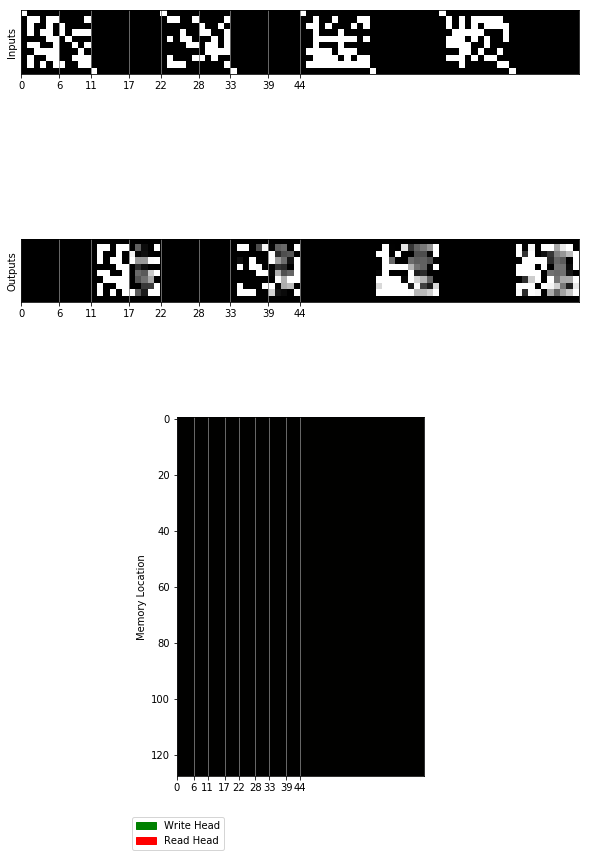

In [6]:
best_indx = np.argmin(losses)
#best_indx = 300
print losses[best_indx]
best_input, best_output, best_memview = inputs[best_indx], outs[best_indx], views[best_indx]

a = visualize_op(best_input, best_output, best_memview)

In [66]:
a = np.squeeze(best_memview['read_weightings'])[36,:]
np.sum(a)

0.99999976